# Instrument Classification
This python script performs classification using 100 audio samples with 5 classes.
To run the script make sure to first download any python packages required (all should be specified in setup.py `packages`). The setup.py script will try to download packages using `pip3 install ...` however, if using anaconda you will need to manually download the packages.

In [41]:
# %% Import python packages

# Run the setup script to download the packages
# * This uses pip install so if your using anaconda
#   you will have to look at setup.packages to see what
#   packages are required.
import setup
import os
from pathlib import Path
import logging

try:
    # Import the python packages required
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    import torchaudio
    from torchsummary import summary

    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.model_selection import StratifiedKFold
    from sklearn.manifold import TSNE

    import pandas as pd
    import numpy as np
    import librosa

    import matplotlib.pyplot as plt
    import seaborn as sb

    %matplotlib inline
    sb.set_theme(context="notebook", style="white", palette="bright")

    from tqdm import tqdm

    # Custom modules
    import dataset
    import plotting
    import feature_extraction
    import dimentionality_reduction
    import models

except ModuleNotFoundError:
    setup.run()
    logging.error('Please re-run the script. If you see this message again, make sure you have downloaded the correct external packages by looking at `setup.py` packages')
    exit()

The code below sets the constant variables for the script.

In [42]:
# %% Setting global constants
# The directory paths for the audio files and annotations
PWD = os.getcwd()
AUDIO_FILES = Path(PWD, 'wavfiles')
ANNOTATIONS = Path(PWD, 'annotations.csv')

# Setting audio and model constants
SAMPLE_RATE = 22050
NUM_SAMPLES = 2*SAMPLE_RATE # two seconds of audio

WIN_LENGTH = 2**11
HOP_LENGTH = 2**10
NCEPS = 13 # 64?
NFILTS = 26

BATCH_SIZE = 32
K_FOLDS = 5
K_NEIGHBORS = 10

To setup the dataset we first need to check the annotations file is created, if not we can iterate through the wav files and create one based off of the file names. This custom function `dataset.create_file_annotations()` then returns a pandas dataframe holding information such as the filename, class label, class ID, and audio length in seconds. Using this information we can plot the class distribution to check if we have too much of an imbalance in any of the classes.

       Filename ClassLabel  ClassID    Length
0  cello-01.wav      cello        0  2.999977
1  cello-02.wav      cello        0  2.999977
2  cello-03.wav      cello        0  2.999977
3  cello-04.wav      cello        0  2.999977
4  cello-05.wav      cello        0  2.999977


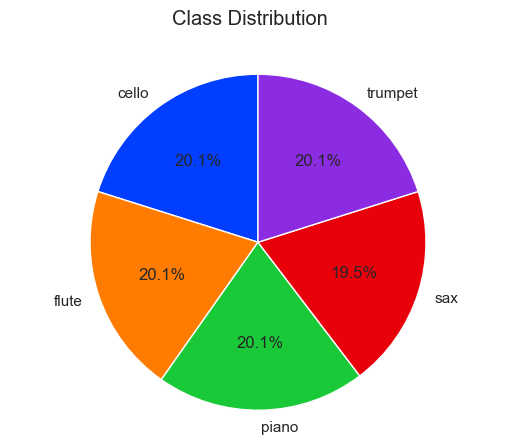

In [43]:
# %% Create annotations file if not already created for the dataset
# or load in the annotations csv file
if not os.path.exists(ANNOTATIONS):
    # Getting the dataframe for the file annotations
    annotations = dataset.create_file_annotations(AUDIO_FILES)
    # Save the dataframe to a CSV file
    annotations.to_csv(path_or_buf=ANNOTATIONS, sep=',', encoding='utf-8', index=False)
    print("Creating annotations .csv file")
else:
    annotations = pd.read_csv(ANNOTATIONS)

# Showing the head of the dataframe
print(annotations.head())

# Plotting the class distribution for the dataset
plotting.plot_class_distribution(annotations)

The annotations data can then be passed into a custom audio dataset object which loads an audio file, cleans it (applying a threshold envelope to remove any silence), resamples and reshapes to mono. A list of transforms have been created to later pass into the dataset to extract multiple features.

In [44]:
# %% Creating the dataset

# Creating a list of feature extractions / transformations that can later be applied to the audio
transforms = [feature_extraction.ExtractRMS(),
              feature_extraction.ExtractSpectralFlatness(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractSpectralCentroid(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractSpectralRolloff(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractZeroCrossingRate(),
              feature_extraction.ExtractMFCC(SAMPLE_RATE, NCEPS, NFILTS, WIN_LENGTH),
              feature_extraction.ExtractGFCC(SAMPLE_RATE, NCEPS, NFILTS, WIN_LENGTH)]

# Creating the dataset
# This dataset performs pre-processing on the audio files
# such as resampling, resizing (to mono), normalization, and feature extraction
# Here just the MFCC transform is passed to the dataset object
audio_dataset = dataset.AudioDataset(annotations, AUDIO_FILES, transforms[5], SAMPLE_RATE, NUM_SAMPLES)

## Feature Extraction

Feature extraction plays a crucial role in music information retrieval (MIR) tasks such as audio classification. Not only does it provide a layer of dimensionality reduction but it can also help to provide a model with the most relevant information to perform the given task.

Here we extract a few features for each class to visualise on a plot.

In [45]:
# %% Displaying each feature extraction for the first audio file in each class
# Creating temporary dictionaries to hold the data and the corresponding class label as a key
tmp_signals = {}
tmp_fft = {}
tmp_zcs = {}
tmp_fbank = {}
tmp_mfccs = {}
tmp_gfccs = {}
tmp_scs = {}
tmp_sfs = {}
tmp_srs = {}

# Getting all the unique class labels
classes = list(np.unique(annotations.ClassLabel))

# Iterating through the classes and selecting the first signal from each to extract features
for c in classes:
    wav_file = annotations[annotations.ClassLabel == c].iloc[0, 1]
    signal, fs = librosa.load(Path(AUDIO_FILES, wav_file), mono=True, sr=None)
    tmp_signals[c] = signal
    tmp_fft[c] = feature_extraction.calculate_fft(signal, fs)
    tmp_zcs[c] = feature_extraction.zero_crossing_rate(signal).T
    tmp_scs[c] = feature_extraction.spectral_centroid(y=signal, sr=fs).T
    tmp_srs[c] = feature_extraction.spectral_rolloff(y=signal+0.01, sr=fs).T
    tmp_sfs[c] = feature_extraction.spectral_flatness(y=signal).T
    tmp_fbank[c] = feature_extraction.logfbank(signal, fs, nfilt=NFILTS, nfft=WIN_LENGTH).T
    tmp_mfccs[c] = feature_extraction.mfcc(signal, fs, numcep=NCEPS, nfilt=NFILTS, nfft=WIN_LENGTH).T
    tmp_gfccs[c] = feature_extraction.gfcc(signal, fs, num_ceps=NCEPS, nfilts=NFILTS, nfft=WIN_LENGTH).T

One of the reasons why we do not use the original time based signal is due to the high-dimensional feature vectors it produces, especially for longer audio clips or high sampling rates; which ultimately increases the computational complexity and can lead to models not generalising. FFT's can also face the problem of lacking invariance and containing redundant or irrelevant information. 

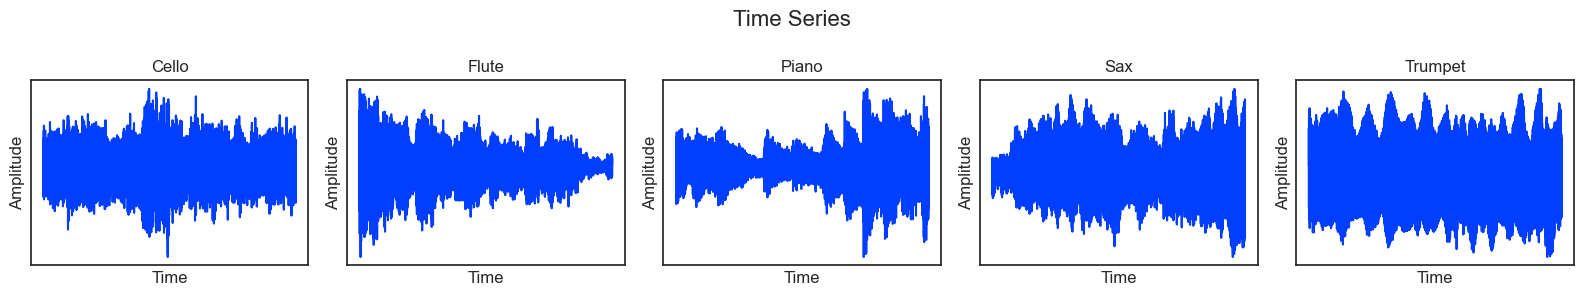

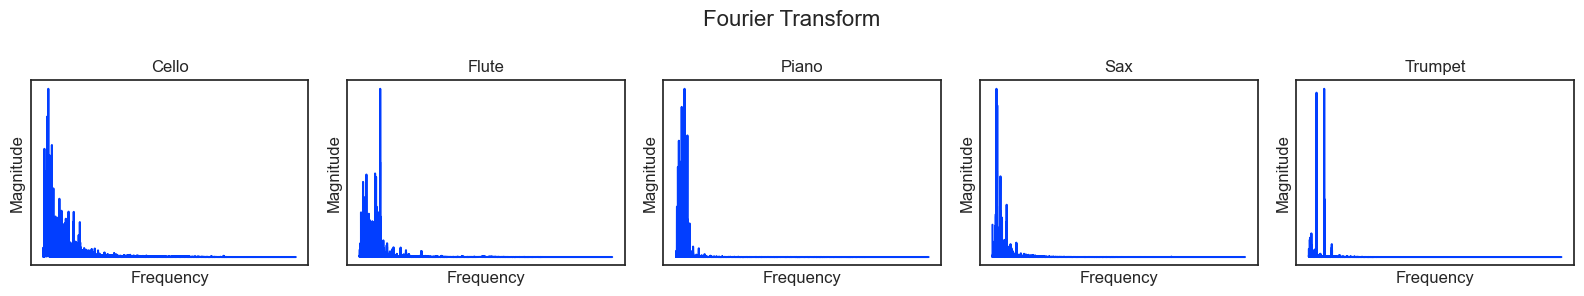

In [46]:
# Plotting the feature extractions of the audio
plotting.plot_signals_time(tmp_signals)
plotting.plot_ffts(tmp_fft)

Breebaart et al. (2004) compared various features such as mel-frequency cepstral coefficients (MFCC), auditory filter-bank temporal envelope (AFTE), standard low-level (SLL) and psychoacoustic (PA) features when training a standard Gaussian framework for both genre and general audio classification.

Some of the SLL features included Root-mean-square (RMS) level, spectral (centroid, bandwidth, and roll-off), zero-crossing rate, band energy ratio, delta spectrum magnitude, and pitch. The PA features included Roughness (the perception of temporal envelope modulations in the range of about 20-150 Hz), loudness (the sensation of signal strength) and sharpness (the spectral density and the relative strength of high-frequency energy) The AFTE features were made using GammaTone filter banks to create gammatone-frequency cepstral coefﬁcients (GFCC).

While the zero-crossing rate is good for percussive audio and capturing some temporal information, other features tend to perform better in most of the literature.

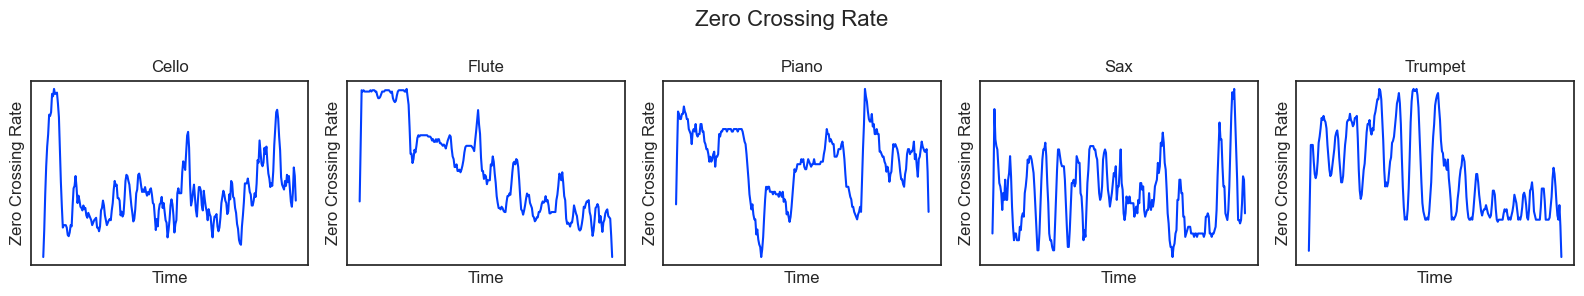

In [47]:
plotting.plot_time_feature(tmp_zcs, 'Zero Crossing Rate')

### Spectral Features

**Spectral Centroid** "indicates at which frequency the energy of a spectrum is centred upon" (Chauhan, 2020).

$$
\mathrm{SC}(m)=\frac{\sum_k f_k|X(m, k)|}{\sum_k|X(m, k)|}
$$

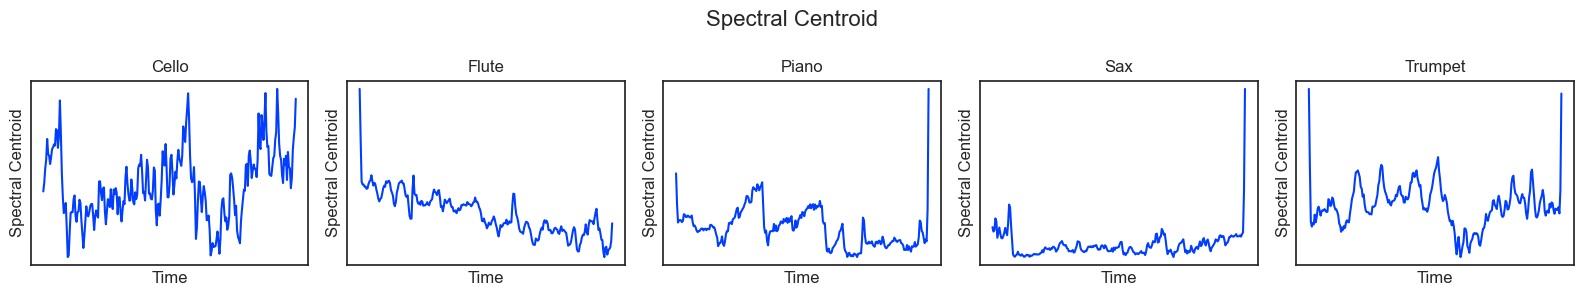

In [48]:
plotting.plot_time_feature(tmp_scs, 'Spectral Centroid')

**Spectral Flatness** measures the ratio of the geometric mean of the spectrum to the arithmetic mean of the spectrum (Johnston, 1988).

$$
\mathrm{SF}(m) = \frac{\left(\prod_k|X(m, k)|\right)^{\frac{1}{K}}}{\frac{1}{K} \sum_k|X(m, k)|}
$$

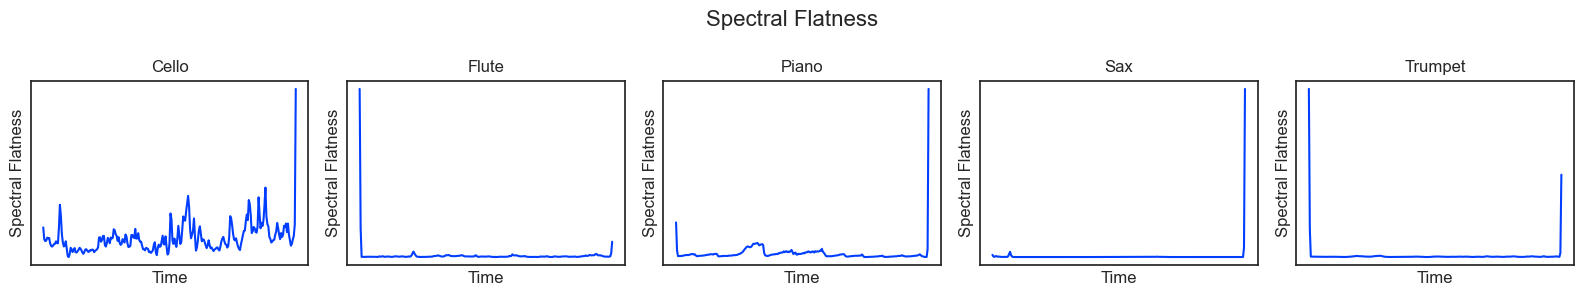

In [49]:
plotting.plot_time_feature(tmp_sfs, 'Spectral Flatness')

**Spectral Roll-off** is a metric that helps determine the bandwidth of an audio signal. It identifies the frequency bin below which a certain percentage of the total energy of the signal is concentrated (Scheirer and Slaney, 1997).

$$
\mathrm{SR}(m) = \frac{{\sum_k |X(m, k)|}}{{\sum_k |X(m, k)|}} \times \text{{roll\_off\_percentage}}
$$

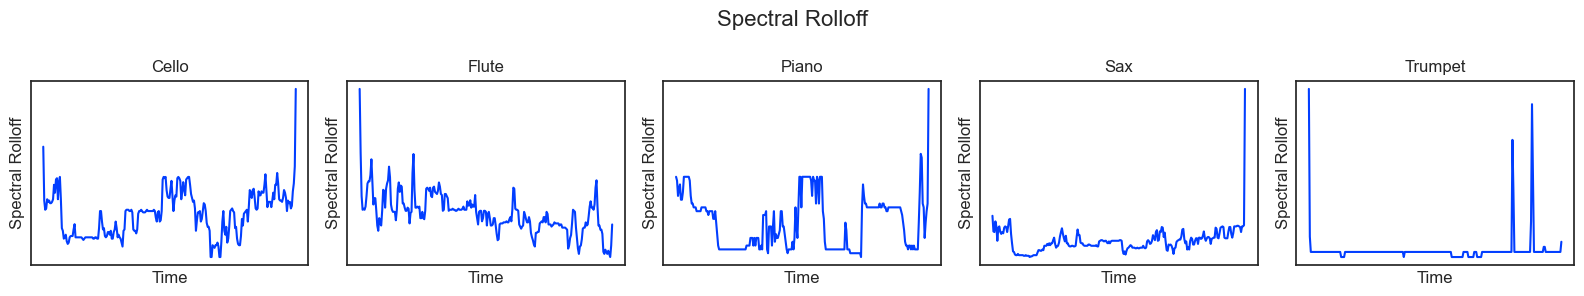

In [50]:
plotting.plot_time_feature(tmp_srs, 'Spectral Rolloff')

While filter banks are used in MIR as a feature extraction technique, MFCC's tend to be preferred over standard log filterbanks due to their perceptual relevance, better dimensionality reduction and robustness to noise.

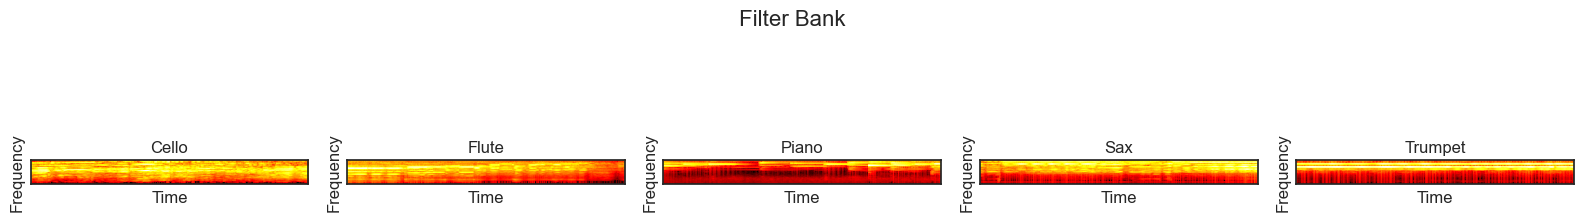

In [51]:
plotting.plot_spectrogram(tmp_fbank, 'Filter Bank')

### GFCC

It was demonstrated that AFTE features (like GFCC's) provided the highest accuracy in Breebaart's study, with MFCC's coming in at a close second. This corresponds with Liu's (2018) study showing 79% accuracy when training an attention based long short-term memory (LSTM+A) network with GFCC's.

**GFCC's** and GammaTone filter bands typically offer enhanced resolution in the lower frequency spectrum and generate a cochlegram, which is relative to the cochlea, an inner ear component.

This can be calculated using the following steps:
```flow
     Gammatone Filter bank
               ↓
Audio Input → FFT → Decimation → Non-Linear Rectification → DCT → GFCC Feature
```

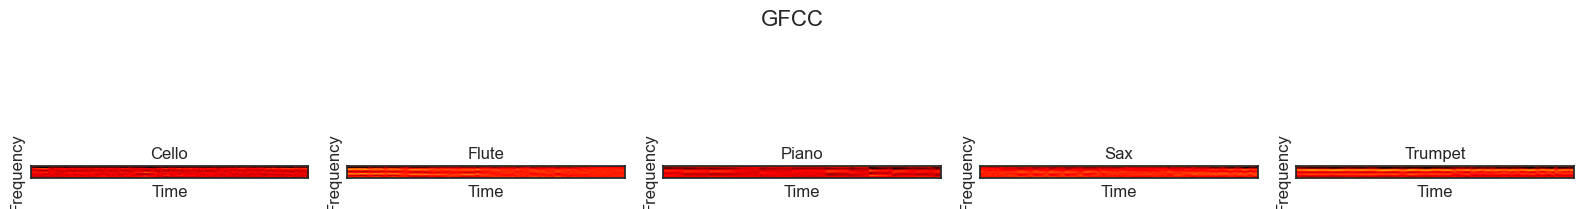

In [52]:
plotting.plot_spectrogram(tmp_gfccs, 'GFCC')


### MFCC

The literature above shows the results for general audio classification, whereas Deng et al. (2008) and Racharla et al. (2020) showed that MFCC and perception-based features dominated in support vector machines (SVM) for instrument classification models with up to 79% accuracy. Rathikarani (2020) also shows 98% accuracy with SVM and 95% with kNN classifiers using MFCC features in instrument classification.

**MFCC's** represent a non-linear 'spectrum-of-a-spectrum' where "the frequency bands are equally spaced on the mel scale, which approximates the human auditory system’s response" (Sdour, 2020). This is calculated similar to the GFCC but using mel filter banks.

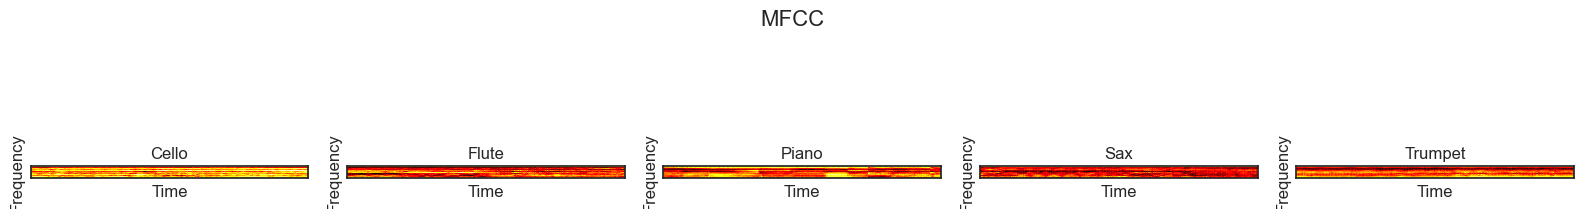

In [53]:
plotting.plot_spectrogram(tmp_mfccs, 'MFCC')

In [54]:
# Deleting the temporary dictionaries
del tmp_signals, tmp_fft, tmp_fbank, tmp_mfccs, tmp_gfccs, tmp_scs, tmp_sfs, tmp_srs

Dupont et al. (2013) used k-nearest neighbour (kNN) classification to compare dimensionality reduction techniques such as Isomap and t-SNE. He used the mean, standard deviation, skewness and kurtosis of the MFCC features.

The following transformations uses the **mean** and **standard deviation** for all features to further reduce the dimensions. Although, it was noted that some dimensionality reduction techniques such as LDA benefitted more from a flattened MFCC and GFCC.

Mean: $$\quad \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$$
Standard Deviation: $$\quad \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$

In [55]:
# %% Extracting all features using the audio dataset object

# Create a pandas DataFrame to hold the features
columns = audio_dataset.get_multiple_transformations_columns(transforms)
features = []
targets = []

for i in range(len(audio_dataset)):
    data, target = audio_dataset.get_multiple_transformations(i, transforms)
    features.append(data)
    targets.append(target)

feature_dataset = pd.DataFrame(np.array(features), columns=columns)
feature_dataset['target'] = targets
labels = audio_dataset.get_class_labels()

It's also important to perform **feature scaling** on the data as it can improve performance in gradient descent convergence when features are within similar ranges. Unscaled features can distort the distance metrics, leading to biased classifications or clustering results when using distance based algorithms such as support vector classification (SVC) or kNN's.

In [56]:
# Apply standardization to the MFCC features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## Feature Selection

There are two main feature selection techniques that can be used in this classification scenario, **Analysis of Variance (ANOVA)** and **Kendall's** algorithm. These methods will compare the variances between features and see how closely they correlate with the targets (Brownlee, 2020). ANOVA is used to select the top 10 features from this dataset. This is done by calculating the F-value for each feature, which measures the ratio of between-group variance to within-group variance. Here's the equation to compute the F-value for a single feature:

$$ F = \frac{{\text{Between-group variance}}}{{\text{Within-group variance}}} = \frac{{\text{MSB}}}{{\text{MSW}}} $$

- Between-group variance is the variance between different groups or classes.
- Within-group variance is the variance within each group or class.
- MSB is the Mean Square Between (or among) groups, calculated as the between-group sum of squares divided by the degrees of freedom between groups.
- MSW is the Mean Square Within groups, calculated as the within-group sum of squares divided by the degrees of freedom within groups.


In [57]:
# Feature selection
fvalue_Best = SelectKBest(f_classif, k=10)
features_best = fvalue_Best.fit_transform(features_scaled, targets)

## Dimensionality Reduction

### PCA

**Principal Component Analysis (PCA)** is a common method for reducing the features in a dataset while maintaining key information and patterns. This is performed by:
1. Normalising the continuous initial variables' range and calculate the mean vector
$$\quad \boldsymbol{\mu} = \frac{1}{N}\sum_{i=1}^{N} \mathbf{x}_i$$
2. Calculating the covariance matrix to detect correlations
$$\quad \mathbf{\Sigma} = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{x}_i - \boldsymbol{\mu}) (\mathbf{x}_i - \boldsymbol{\mu})^T$$
3. Computing the eigenvectors and eigenvalues of the covariance matrix to identify the main components
$$\quad \mathbf{\Sigma v}_i = \lambda_i \mathbf{v}_i \quad \text{for } i = 1, 2, ..., D$$
4. Formulate a feature vector to determine which principal components to retain
5. Transforming the data along the axes of principal components
$$\quad \mathbf{Y} = \mathbf{X} \mathbf{W}$$

The code below shows the cumulative explained variance along various dimensions of the PCA components. The red dashed line shows the best dimension.

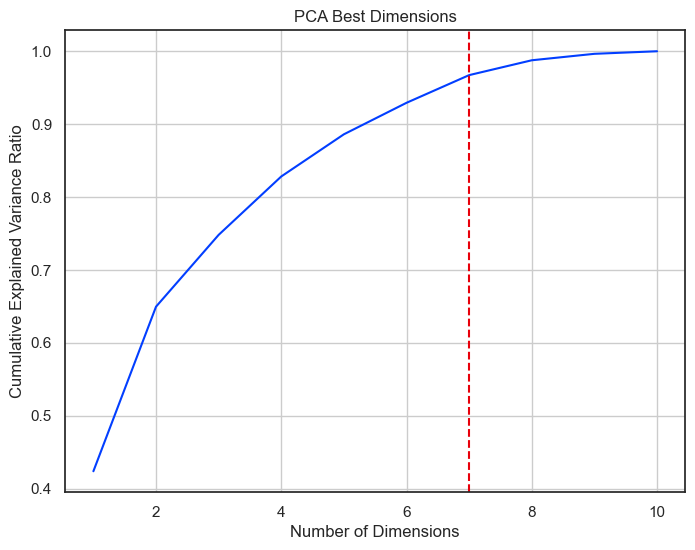

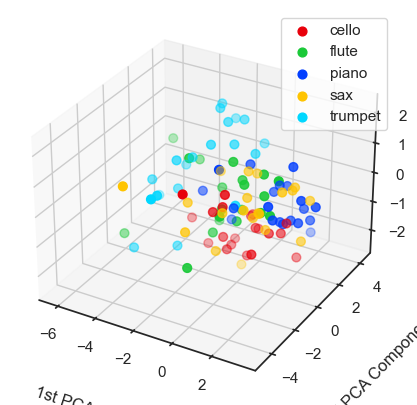

In [58]:
# Apply custom PCA
pca = dimentionality_reduction.PCA(-1)
features_pca = np.real(pca.fit_transform(features_best))

def get_best_dim(dr):
    # Getting the explained variance ratio
    explained_variance_ratio = dr.get_explained_variance()
    # Calculate the cumulative explained variance ratio
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    # Find the number of dimensions with the highest explained variance
    best_dimensions = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
    return explained_variance_ratio, cumulative_explained_variance_ratio, best_dimensions

# Calculate and plot the explained variance ratio for each principal component
pca_evr, pca_cevr, pca_bd = get_best_dim(pca)
plotting.plot_explained_variance(pca_evr, pca_cevr, pca_bd, 'PCA')

# Plotting PCA components (first 3 dimensions) on a 3D scatter plot
plotting.plot_dimentionality_reduction(features_pca, targets, labels, 'PCA')

### t-SNE

**t-distributed Stochastic Neighbor Embedding (t-SNE)** is a unsupervised method for dimensionality reduction on non-linear data, primarily used for preserving small pairwise distances unlike PCA. Van Der Maaten (2014) improves the Barnes-Hut implementation of the t-SNE which drastically accelerates the process using tree based algorithms as shown below. Pál et al. (2020) shows that t-SNE outperforms PCA, Isomap and Self-Organizing Maps (SOM) when using MFCC features for general audio dimensionality reduction (DR) in machine learning (ML).

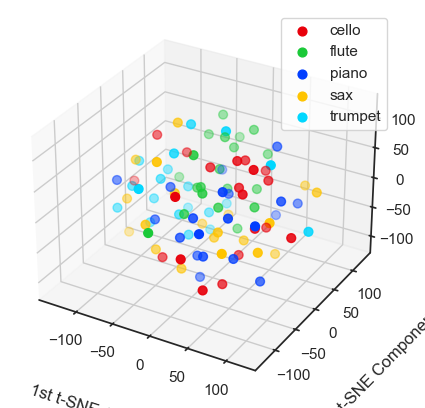

In [59]:
# Testing other dimensionality reduction techniques
features_tsne = TSNE(n_components=3, method='barnes_hut').fit_transform(features_best, targets)

plotting.plot_dimentionality_reduction(features_tsne, targets, labels, 't-SNE')

### LDA

As stated by Dupont et al. (2013), **Linear Discriminant Analysis (LDA)** is a common DR technique used in classification algorithms. This supervised DR method finds the linear combinations of features that best separate multiple classes while maximizing their between-class distance and minimizing their within-class variance. LDA is performed by:
1. Calculate the mean vectors for each class by averaging the feature vectors belonging to that class.
$$\quad \boldsymbol{\mu}_k = \frac{1}{N_k}\sum_{i=1}^{N_k} \mathbf{x}_{ki} \quad \text{for } k = 1, 2, ..., K$$
2. Determine the within-class scatter matrix by computing the scatter matrix for each class and summing them up.
$$\quad \mathbf{S}_W = \sum_{k=1}^{K} \sum_{i=1}^{N_k} (\mathbf{x}_{ki} - \boldsymbol{\mu}_k) (\mathbf{x}_{ki} - \boldsymbol{\mu}_k)^T$$
3. Derive the between-class scatter matrix by computing the mean vector of all data points across all classes and then calculating the scatter matrix between classes.
$$\quad \mathbf{S}_B = \sum_{k=1}^{K} N_k (\boldsymbol{\mu}_k - \boldsymbol{\mu}) (\boldsymbol{\mu}_k - \boldsymbol{\mu})^T$$
4. Find the eigenvectors and eigenvalues of the matrix formed by the product of the inverse of the within-class scatter matrix and the between-class scatter matrix.
$$\quad \mathbf{S}_W^{-1} \mathbf{S}_B \mathbf{w}_i = \lambda_i \mathbf{w}_i \quad \text{for } i = 1, 2, ..., D$$
5. Select the top k eigenvectors corresponding to the largest eigenvalues to form the projection matrix.
6. Project the original data onto the subspace formed by the selected eigenvectors to obtain the lower-dimensional representation of the data.

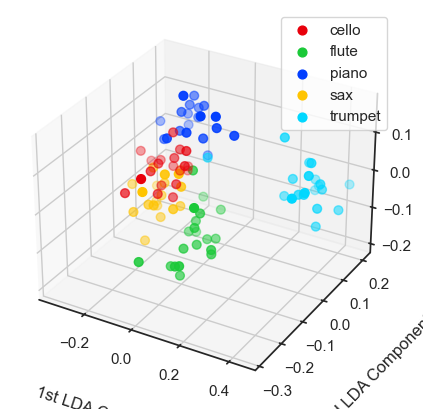

In [60]:
# Apply custom LDA
lda = dimentionality_reduction.LDA(-1)
features_lda = np.real(lda.fit_transform(features_scaled, targets))

plotting.plot_dimentionality_reduction(features_lda, targets, labels, 'LDA')

## Classification Models

As this dataset provides targets, supervised learning is most likely the best approach. As mentioned above, some common supervised learning models for audio classification are SVC's and kNN's. The script below uses k-fold validation to provide an accuracy score for each model on each dimensionality reduction technique.

## Bibliography

Reference List
Breebaart, J. and McKinney, M. (01 2004) ‘Features for Audio Classification’, in. doi: 10.1007/978-94-017-0703-9.


Brownlee, J. (2020) How to Choose a Feature Selection Method For Machine Learning. Available at: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/.


Chauhan, N. S. (2020) Audio Data Analysis Using Deep Learning with Python. Available at: https://www.theaidream.com/post/audio-data-analysis-using-deep-learning-with-python-part-1.


Deng, J. D., Simmermacher, C. and Cranefield, S. (2008) ‘A Study on Feature Analysis for Musical Instrument Classification’, IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), 38, pp. 429–438. Available at: https://api.semanticscholar.org/CorpusID:1408712.


Dupont, S. et al. (2013) ‘Nonlinear dimensionality reduction approaches applied to music and textural sounds’, in 2013 IEEE International Conference on Multimedia and Expo (ICME), pp. 1–6. doi: 10.1109/ICME.2013.6607550.


Johnston, J. D. (1988) ‘Transform coding of audio signals using perceptual noise criteria’, IEEE Journal on Selected Areas in Communications, 6(2), pp. 314–323. doi: 10.1109/49.608.


Liu, G. K. (2018) ‘Evaluating Gammatone Frequency Cepstral Coefficients with Neural Networks for Emotion Recognition from Speech’, CoRR, abs/1806.09010. Available at: http://arxiv.org/abs/1806.09010.


Pál, T. and Várkonyi, D. (09 2020) ‘Comparison of Dimensionality Reduction Techniques on Audio Signals’.


Racharla, K. et al. (2020) ‘Predominant Musical Instrument Classification based on Spectral Features’, in 2020 7th International Conference on Signal Processing and Integrated Networks (SPIN). IEEE. doi: 10.1109/spin48934.2020.9071125.


Rathikarani, V., Dhanalakshmi, P. and S., P. (05 2020) ‘Classification of Musical Instruments using SVM and KNN’, International Journal of Innovative Technology and Exploring Engineering, 9, pp. 2278–3075. doi: 10.35940/ijitee.G5836.059720.


Scheirer, E. D. and Slaney, M. (1997) ‘Construction and evaluation of a robust multifeature speech/music discriminator’, 1997 IEEE International Conference on Acoustics, Speech, and Signal Processing, 2, pp. 1331–1334 vol.2. Available at: https://api.semanticscholar.org/CorpusID:12331395.


Sdour, A. (2021) From «MFCCs xor GFCCs» to «MFCCs and GFCCs» : Urban Sounds Classification case study | Towards Data Science. Available at: https://towardsdatascience.com/from-mfccs-xor-gfccs-to-mfccs-and-gfccs-urban-sounds-classification-case-study-a087ac007901.


Van Der Maaten, L. (2014) ‘Accelerating t-SNE using tree-based algorithms’, J. Mach. Learn. Res. JMLR.org, 15(1), pp. 3221–3245.


Zaman, K. et al. (2023) ‘A Survey of Audio Classification Using Deep Learning’, IEEE Access, 11, pp. 106620–106649. doi: 10.1109/ACCESS.2023.3318015.